In [113]:
import numpy as np
from ipynb.fs.full.DataFormatting import pd, ast, KEYWORDS, df, noisy_punct, ks
from ipynb.fs.full.PatternMining import indices_of_first_attempts_per_user, apply_prefixSpan
import matplotlib.pyplot as plt

## Comparing text insertions with deletions

First what we want to do is count the number of insertions and deletions for each student. 

**We consider an insertion as being any character that was typed without being in  `KEYWORDS`. (whitespaces included)**

**We consider deletions as being any character being equal to 'Backspace' or 'Delete'.**

we will create a tuple for each student of the form ```(total insertions, total deletions)```.
We create the same thing for each set of keystrokes in the dataset but it will be useful for later.

Also, what we do for each user: map their typing to insertions and deletions as **0s for insertions, 1s for deletions** and try to see what different sequences of inserts/delete all users have.

In [114]:
all_ks = []
for keystrokes in ks.values:
    k = []
    for i, json in enumerate(keystrokes):
        if json != None:
            k.append(json)
    all_ks.append(k)


In [115]:
dframe = pd.read_csv('data/keystrokes-recipes.csv')
all_keystrokes = all_ks
sorted_users = sorted(set(df['user_id'].values))
ins_del_dict = {'insert': 0, 'delete': 1}
student_sequences = []
recipe_sequences = []

recipe_insertions_deletions = []
user_insertions_deletions = []
for user in sorted_users:
    #idk why but np.where here returns a tuple of the form (array,...) so the indices are in tuple[0]
    indices_where_written = np.where(dframe['user_id'] == user)
    insertions = 0
    deletions = 0
    student_sequence = []
    for index in indices_where_written[0]:
        users_keystrokes = all_keystrokes[index]
        recipe_sequence = []
        recipe_insertion = 0
        recipe_deletion = 0
        for recipe_dic in users_keystrokes:
            char = recipe_dic['character']
            if char not in KEYWORDS:
                insertions += 1
                recipe_insertion += 1
                student_sequence.append(ins_del_dict['insert'])
                recipe_sequence.append(ins_del_dict['insert'])
            elif char == 'Backspace' or char == 'Delete':
                deletions += 1
                recipe_deletion += 1
                student_sequence.append(ins_del_dict['delete'])
                recipe_sequence.append(ins_del_dict['delete'])

        recipe_sequences.append(recipe_sequence)       
        recipe_insertions_deletions.append((recipe_insertion, recipe_deletion))
                        
    student_sequences.append(student_sequence)
    user_insertions_deletions.append((insertions, deletions))


Now we plot the total number of insertions and deletions for **each user**.

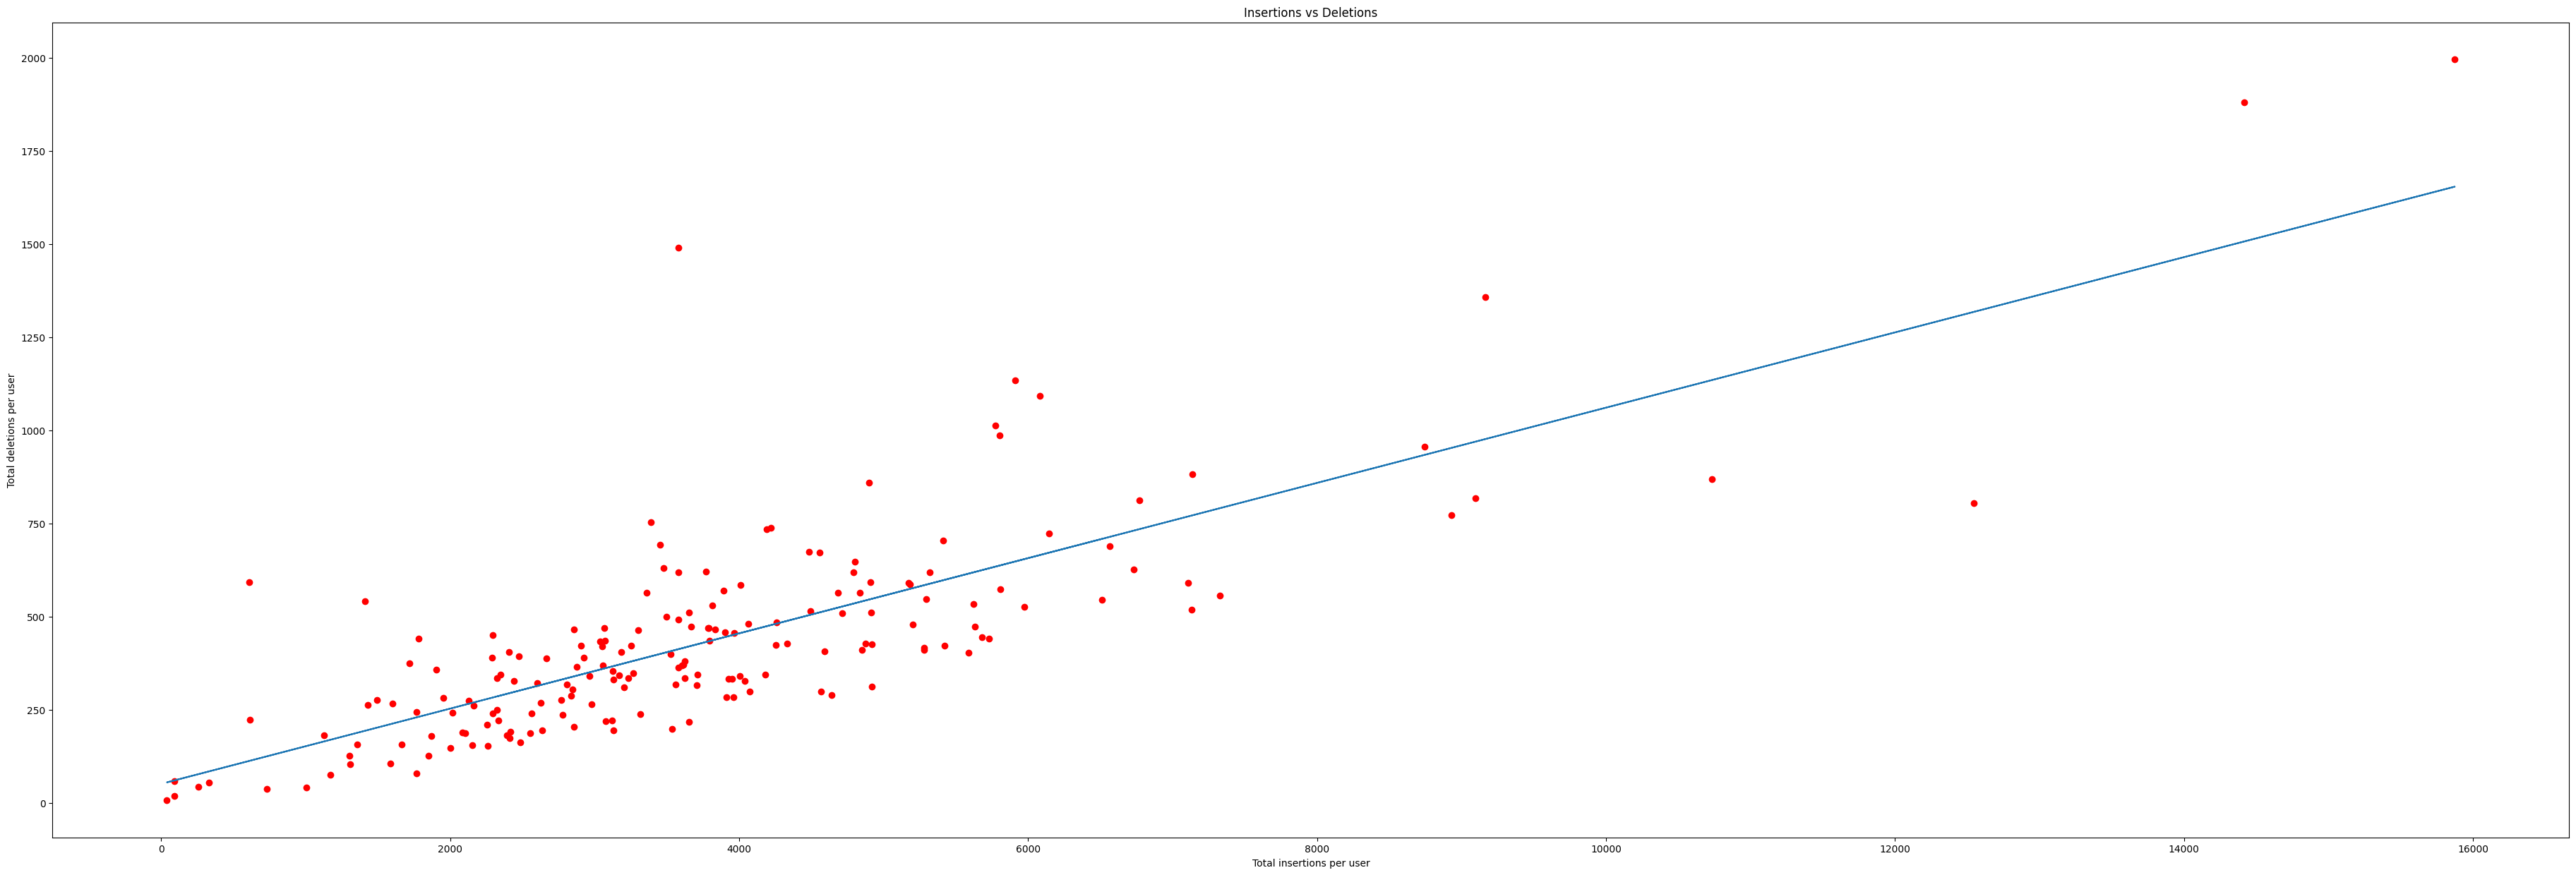

In [116]:
user_df = pd.DataFrame(user_insertions_deletions, columns=['insertions', 'deletions'])

X = user_df['insertions'].values.reshape(-1,1)
Y = user_df['deletions'].values.reshape(-1,1)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X,Y)
y_pred = regressor.predict(X)
plt.scatter(X, Y, color='r')
plt.plot(X, y_pred)
plt.title('Insertions vs Deletions')
plt.xlabel('Total insertions per user')
plt.ylabel('Total deletions per user')
plt.show()


Now for any user, we map their insertions and deletions to the % of each and have pandas plot the % at each revision step. 
We also have a function that plots the total number of insertions and deletions.

Revision steps occur at each set of keystrokes when the `user_id` is the same. However, it is important to note some revision steps are not a revision steps but rather the start of another recipe. This is clearly visible in the plots when the number of insertions at step n is much smaller than the number of insertions at step n+1

We created a plot that takes any user index and returns the amount of revision they had with the % of deletions and insertions at each step

Here are useful functions.


In [117]:
def plot_percentages_for_user(user_index):
    """
    Plots the percentages of insertions and deletions at each revision step t
    A bit of hardcoded constants but the data won't change overnight so ...
    Args:
        user_index (int): index of user to plot
    """
    assert user_index >= 0 and user_index < 187
    user = None
    if user_index == 186:
        user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:]
    else:
        user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:indices_of_first_attempts_per_user[user_index+1]]
    percentage = []
    for i, (insert,deletes) in enumerate(user):
        s = insert + deletes
        percentage.append((round(insert/s*100, 2), round(deletes/s*100, 2)))

    dframe = pd.DataFrame(percentage, columns=['insertion %', 'deletion %'])
    dframe.plot(kind='bar', xlabel='revision step for user ' + str(user_index) + ' : ' + sorted_users[user_index], ylabel='percentage', figsize=(5,3))
    


def plot_stats_for_user(user_index):
    """
    Same idea as percentages but this method plots the absolute numbers 
    of insertions and deletions

    Args:
        user_index (int): index of user to plot
    """
    assert user_index >= 0 and user_index < 187
    user = None
    if user_index == 186:
        user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:]
    else:
        user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:indices_of_first_attempts_per_user[user_index+1]]
    dframe = pd.DataFrame(user, columns=['insertions', 'deletions'])
    dframe.plot(kind='bar', xlabel='revision step for user ' + str(user_index) + ' : ' + sorted_users[user_index], figsize=(5,3))
    print(sorted_users[user_index])



def collect_data_from_user(user_index):
    """
    Collects all the content a user writes on the plaform.

    Args:
        user_index (int): user index to collect data from

    Returns:
        pd.DataFrame: a sublist of tuples from the given users revisions
    """
    assert user_index >= 0 and user_index < 187
    user = None
    if user_index == 186:
        user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]:]
    else:
        user = recipe_insertions_deletions[indices_of_first_attempts_per_user[user_index]: indices_of_first_attempts_per_user[user_index+1]]
    return pd.DataFrame(user, columns=['insertions', 'deletions'])

We can plot three user's data at random

60fd1cafe3de7892fe9b3bd4
5a9bbda1f6dfdd0001ea9639
628781515f29a0394e23b15b


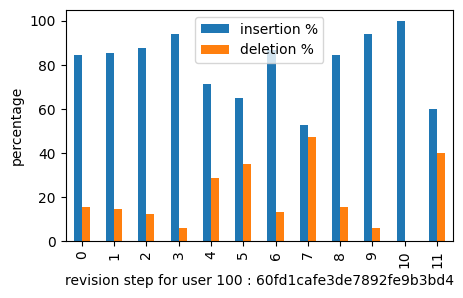

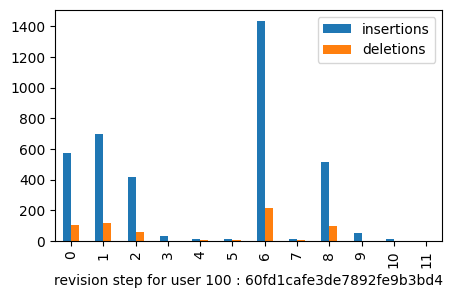

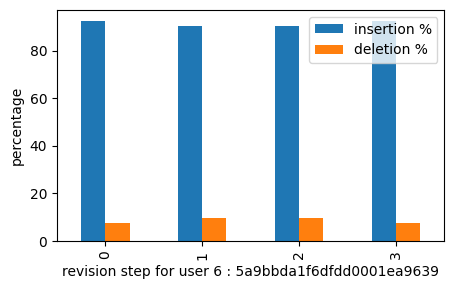

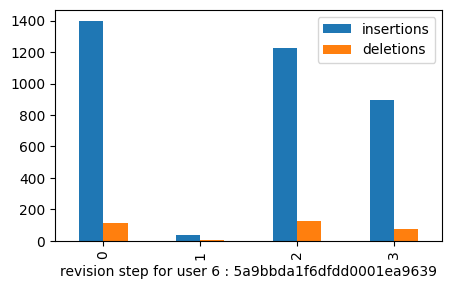

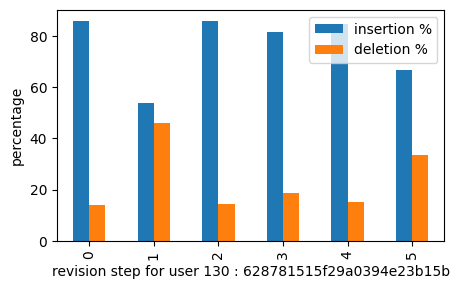

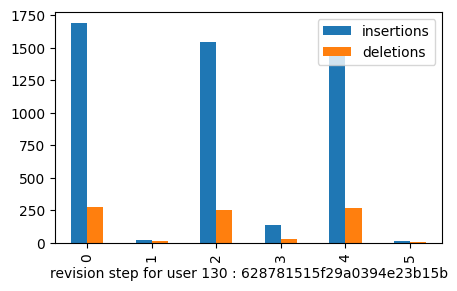

In [118]:
plot_percentages_for_user(100)
plot_stats_for_user(100)
plot_percentages_for_user(6)
plot_stats_for_user(6)
plot_percentages_for_user(130)
plot_stats_for_user(130)

We can see the amount of revision fluctuates a lot between users at each revision step but there is a general trend. 
My guess is the differences come from the different groups of users.

### Finding patterns in student insert/delete sequences

We create a function that will apply `PrefixSpan` on the nth revision step for each user.
That means, for revision step 0, the method will apply PS on the first things student write, without having had any suggestions from the model.
if $n = 1$, that means we look at patterns in writing after the first revision with suggestions from the ML model. 
Because users write multiple recipes, the only revision steps worth looking at for now are $n = \{0,1,2,3\}$

In [119]:
def compute_prefix_span_on_revision_step(n, minSupport=.3, maxPatternLength=10):
    """
    Args:
        n (int): the revision step - usually between 0 and 3
        minSupport (float):  Defaults to 0.3.
        maxPatternLength (int):  Defaults to 10.
    """
    #We must select only users that have n revisions - not everyone has 10 revision for example.
    users_with_n_revisions = [indices_of_first_attempts_per_user[i]+n if indices_of_first_attempts_per_user[i+1] - indices_of_first_attempts_per_user[i] >= n else -1 for i in range(len(indices_of_first_attempts_per_user)-1)]
    nth_revision = []
    for index in users_with_n_revisions:
        if index != -1:
            users_nth_sequence = recipe_sequences[index]
            nth_revision.append(users_nth_sequence)

    return apply_prefixSpan(nth_revision, minSupport=minSupport, maxPatternLength=maxPatternLength, title="Prefix Span applied on users at revision step " + str(n))


#sequences = compute_prefix_span_on_revision_step(0, minSupport=.9, maxPatternLength=2)

We analyse the sequences of inserts and deletions from each users first time they write on the platform. To check what they write before they get any suggestions

In [120]:
#compute_prefix_span_on_revision_step(1, minSupport=.4, maxPatternLength=7)

What we can see is users don't generally revise their text the first time they submit it for analysis. In the sense that they don't delete a portion of their text and rewrite it. And this confirms what we see with % of insertions at revision time 0. And when users revise for the first time, we notice a slight increase in the number of deletions.

## Bubble plot

In [121]:
from matplotlib.ticker import MaxNLocator

def bubble_plot(data, indices, vertical=False, xlabel="", ylabel="", text_to_display="", group_characteristics=""):
    list_of_df = [df for df in data]
    dframes = pd.concat(list_of_df)

    ax = plt.figure().gca()
    y = [[i]*len(list_of_df[i]) for i in range(len(list_of_df))]
    x = [np.arange(len(y_i)) for y_i in y ]
    x = [index for sub in x for index in sub]
    y = [i for sub in y for i in sub]

    z = np.array([dframes['insertions']])


    ax = plt.subplot()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    """     textstr = '\n'.join((
        r'$\mu=%.2f$' % (1, ),
        r'$\mathrm{median}=%.2f$' % (2, ),
        r'$\sigma=%.2f$' % (3, ))) 
    """


# these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
    ax.text(0.8, 0.95, text_to_display, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


    new_props = dict(boxstyle='round', facecolor='lightcoral', alpha=0.5)
    ax.text(0.05, 0.95, group_characteristics, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=new_props)
        
    if vertical:
        plt.xlabel(xlabel=xlabel, fontsize=20)
        plt.ylabel(ylabel=ylabel, fontsize=20)
        plt.rcParams["figure.figsize"] = (len(indices) + 6, 15)
        ax.scatter(y, x, s=z*5, label=xlabel, c="darkcyan", alpha=0.8, linewidths=2)
        ax.scatter(y, x, s=np.array([dframes['deletions']])*5 , label='deletions', c="blue", alpha=0.4, linewidths=2)
    else :
        plt.xlabel(xlabel=xlabel, fontsize=20)
        plt.ylabel(ylabel=ylabel, fontsize=20)
        plt.rcParams["figure.figsize"] = (15, len(indices) + 6)
        ax.scatter(x, y, s=z*10, label='inserts', c="red", alpha=0.4, linewidths=2)
        ax.scatter(x, y, s=np.array([dframes['deletions']])*5 , label='deletions', c="blue", alpha=0.4, linewidths=2)



In [122]:
def bubble_plot_all_recipes(indices=np.arange(10), vertical=False):
    """
    Computes the bubble plot for a certain number of users and at certain indices if specified.
    Indices represent users - so one can plot for user 0, 3, 5, 20 ... if required.
    It will be useful when we know who belonged to which group so that we can plot the data for users in each group

    Args:
        n_users (int): the max number of users to display
        indices (list): plot the data at for given users - WILL BE USEFUL WHEN WE KNOW WHICH USER IS IN WHICH GROUP !!!!! So that we can plot the data for those users and extract info
        vertical (bool, optional): Set to true to display data vertically. Defaults to False.
    """
    dframes = []
    for i, user in enumerate(sorted_users):
        if i in indices:
            dframe = collect_data_from_user(i)
            dframe.reset_index(inplace=True)
            dframes.append(dframe)
    bubble_plot(dframes, indices=indices, vertical=vertical, xlabel="All revisions for users", ylabel="Revision step")


#bubble_plot_all_recipes(vertical=True)


## Separating writing sessions

We use distance metrics between each recipe written and keep the indices to separate the different recipes. This alleviates most of the work from the previous idea -- and is more safe to use -- safer than writing my own algorithm. The previous idea consisted of checking the number of inserts between each revision and check for a spike. We were also going to check the time it took between each submission and consider a recipe as new if the difference was important.

We download a glove model (similar to word2vec) which is already trained on wikipedia, where each word is represented as a 50-dimensional vector.

We will separate every recipe written in sessions so that we can look what happens at each revision session for every recipe written.

The algorithm works recursively. For each recipe it computes the distance with the following recipes until it finds a recipe with which $1 - distance <.995$. When it does find one, it restarts the whole process from the index of said recipe with the accumulator containing the index.

In [123]:
#Load the model
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")

In [124]:
from scipy import spatial

def preprocess(s):
    res = ""
    for i, char in enumerate(list(s)):
        if char not in noisy_punct:
            res += char    
    res = [i.lower() for i in res.split()]
    res = list(filter(lambda _ : _ not in noisy_punct, res))
    return res

def get_vector(s):
    """
    Get the vector representation of a sentence from the model

    Args:
        s (str): text

    """
    arr = []
    for i in preprocess(s):
        key = None
        try: 
            key = model[i]
            arr.append(key)
        except:
            continue

    arr = np.array(arr)
    return np.sum(arr, axis=0)

recipes = df['recipe'].values


def compute_recipe_indices(start_index, acc):
    """
    Computes the list of indices where each recipe in the dataset begins
    Basically, user 0 writes 3 recipes:
    starts writing at t = 0, revises once at t = 1, a second time at t = 2 and 
    starts a new recipe at t = 3, then this function will return [0, 3] 

    Args:
        start_index (int): index to compare with the other recipes
        acc (list(int)): list to return

    Returns:
        list(int) : list of indices of beginning of each recipe
    """
    if start_index >= 1089:
        return acc
    vec = get_vector(recipes[start_index])
    for i in range(start_index, 1090):
        dist = 1 - spatial.distance.cosine(vec, get_vector(recipes[i]))
        if dist < .995:
            acc.append(i)
            return compute_recipe_indices(i, acc)


recipes_indices = compute_recipe_indices(0, [0])

"""
The algorithm works relatively well and we do have approximately 3 recipes per user (some write less, some write more). 
However, looking at the data, we see that some recipes are the same at certain indices but the algorithm 
computes a large distance -- one can argue that perhaps there are so many additions that it increases said distance

So looking at the data, I detected several recipes out that need to be removed. 
"""


#I looked at the data by hand and tagged these as needing to be removed.
recipes_to_remove = [30, 40, 43, 52, 94,151, 166, 184, 212, 238, 248, 256, 268, 274, 301, 318, 334,
365, 374, 404, 413, 423, 458, 491, 510, 554, 560, 561, 580, 611, 674, 767, 769, 780, 786, 802, 840, 868, 914, 919, 922, 924,
933, 936, 937, 938, 954, 999, 1001, 1014, 1043, 1085]

to_add = [181 , 202, 261, 388, 529, 559, 596, 688, 793, 830, 879, 881,917, 1001, 1034, 1085]

for i in recipes_to_remove:
    recipes_indices.remove(i)

for i in to_add:
   recipes_indices.append(i)

recipes_indices = sorted(recipes_indices)
a = np.where(np.array(recipes_indices) == 181)
rec = [df['recipe'][i] for i in recipes_indices]
users = [df['user_id'][i] for i in recipes_indices]
dframe = pd.DataFrame([recipes_indices, rec,users]).transpose()
dframe.columns =['recipe index in data', 'recipe', 'user id']
dframe.head()

C:\Users\lucam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\spatial\distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,recipe index in data,recipe,user id
0,0,Brown 1 pound of hamburger meat. Drain the gre...,55ae64defdf99b3f864653e7
1,3,"1) Cook chicken as desired (boiled, pan seared...",55ae64defdf99b3f864653e7
2,6,28 oz or so of potatoes cubed\n1 8oz of cream ...,55ae64defdf99b3f864653e7
3,9,To serve 4 people (your family!)\n\n\n-You wil...,55d22025cc2b18000c0b9d9c
4,11,No Bake Cheesecake recipe\n\n\nServes: Whoever...,55d22025cc2b18000c0b9d9c


Now we have an array of indices at which there is a new recipe.
Now we have to map the recipes to the users.
The idea is to transform the indices: ```[0,3,6,9,11,12,...]``` $\rightarrow$ ```[(0, [0,3,6]), (1, [9,11,12]), ... ]```

However since not everyone has 3 recipes, we can't simply group every 3 recipes together as that would map some recipes to users that havent written them.
What we do instead is use pandas methods that does everything so nicely.

In [125]:
#map each user to the index of each recipe they wrote
map_ = dframe.groupby('user id')["recipe index in data"].apply(list)
a = list(filter(lambda arr : len(arr[1]) < 3, enumerate(map_)))
print(a)

[(16, [93, 96]), (33, [196]), (109, [680]), (127, [775, 777]), (144, [859, 860])]


Now we create a function that plots the number of insertions per user per session. For example, user 1 writes 3 recipes and has 9 writing sessions so we want to differentiate each session to see what happens each time he writes a recipe.

In [126]:
def plot_users_sessions(user_index):
    print(sorted_users[user_index])
    recipe_indices = map_[user_index].copy()
    if user_index == 186: last_index_where_written = 1091
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)
    for i, index in enumerate(recipe_indices):
        if i + 1 < len(recipe_indices):
            revisions = recipe_insertions_deletions[index: recipe_indices[i+1]]
            print(revisions)
            dframe = pd.DataFrame(revisions, columns=['insertions', 'deletions'])
            dframe.plot(kind='bar', xlabel='writing session number ' + str(i+1) +' for user '+ str(user_index) + ' : ' + sorted_users[user_index], figsize=(5,3))


def get_data_per_session(user_index):
    revisions = []
    recipe_indices = map_[user_index].copy()
    if user_index == 186: last_index_where_written = 1091
    else: last_index_where_written = indices_of_first_attempts_per_user[user_index + 1]
    recipe_indices.append(last_index_where_written)
    for i, index in enumerate(recipe_indices):
        if i + 1 < len(recipe_indices):
            rev = recipe_insertions_deletions[index: recipe_indices[i+1]]
            dframe = pd.DataFrame(rev, columns=['insertions', 'deletions'])
            revisions.append(dframe)
    return revisions

In [127]:
def bubble_plot_recipe(recipe_num, indices, vertical=False, xlabel="",  ylabel="", text_to_display="", group_characteristics=""):
    dframes = []
    for i, _ in enumerate(sorted_users):
        if i in indices:
            try: 
                dframe = get_data_per_session(i)[recipe_num]
                dframe.reset_index(inplace=True)
                dframes.append(dframe)
            except: 
                dframes.append(pd.DataFrame())
    bubble_plot(dframes, indices=indices, vertical=vertical, xlabel=xlabel, ylabel=ylabel, text_to_display=text_to_display, group_characteristics=group_characteristics)

## Matching the users to their groups

If we follow the logic of the paper on Relex, we have the following structure for the groups:

| Group 1 | Group 2| Group 3 | Group 4| Control Group
| :----: | :---:|:----:|:---:|:-:|
Reflective Prompts | No Reflective Prompts | Reflective Prompts | No Reflective Prompts | No Reflective Prompts
Adaptive Feedback | Adaptive Feedback| Non-Adaptive feedback  |Non-Adaptive feedback | No feedback

In [128]:
matching_data = pd.read_csv('data/group_matching.csv')
s = matching_data.sort_values(by=['group', 'user_id'], ascending=True)

"""
    Basically what we do here is simple. We have the data matching each user to which group they belong to.
    So what we do is we create an array INDICES. We create a dictionnary which maps each group to the users in it.
    Then iterate over the users of each group and find their index in the sorted users array. 

    so INDICES has 5 arrays, each containing the indices of the users in that group.
    
"""
groups = {1: [], 2: [], 3: [], 4: [], 5: []}
for i, dic in enumerate(s.values):
    user = dic[1]
    if user in sorted_users:
        groups[dic[0]].append(user)

INDICES = []
for group in range(1,6):
    indices = []
    for user in groups[group]:
        i = np.where(np.array(sorted_users) == user)
        indices.append(i[0][0])
    INDICES.append(indices)

In [129]:
def plot_group_at_recipe(group_n, recipe_number=0, vertical=False, xlabel="", ylabel="", text_to_display="", group_characteristics=""):
    """
    Plots the bubble plot for group n at the nth recipe they write

    Args:
        group_n (int): between 1 and 5. Represents the group we want to plot
        recipe_number (int): the recipe we want to plot. Defaults to 0.
        vertical (bool): choose how to display the plot. Defaults to False.
    """
    bubble_plot_recipe(recipe_num=recipe_number, indices=INDICES[group_n-1], vertical=vertical, xlabel=xlabel, ylabel=ylabel, text_to_display=text_to_display, group_characteristics=group_characteristics)

In [130]:
max_num_revisions_each_group = []

def data_computation_on_groups(nth_revision):
    max_revs_per_group = []
    mean_per_group = []
    var_per_group = []

    avrg_revision_lengths = []
    for group in INDICES:
        data_for_group = []
        group_revisions = []
        for user in group:
            try:
                data_for_sessions = get_data_per_session(user)[nth_revision]
            except: continue
            data_for_sessions = data_for_sessions.values
            l = list(map(lambda _ : len(_) , data_for_sessions))
            data_for_group.append(len(l)-1)     
            inserts = list(map(lambda _ : _[0], data_for_sessions))
            if len(inserts) > 1:
                with_revision = inserts[1:] 
                for elem in with_revision:
                    group_revisions.append(elem)

        

        avrg_revision_lengths.append(np.mean(group_revisions))
        mean_per_group.append(np.mean(data_for_group))
        var_per_group.append(np.var(data_for_group))
        max_revs_per_group.append(max(data_for_group))
    return max_revs_per_group, mean_per_group, var_per_group, avrg_revision_lengths

a = data_computation_on_groups(nth_revision=0)
print(a)


([5, 10, 3, 4, 4], [1.225, 1.8823529411764706, 0.7575757575757576, 0.8717948717948718, 1.3], [1.174375, 4.6920415224913485, 0.4260789715335169, 0.6758711374095989, 0.9099999999999999], [148.57142857142858, 63.265625, 158.76, 191.5, 1047.5576923076924])


55d22025cc2b18000c0b9d9c


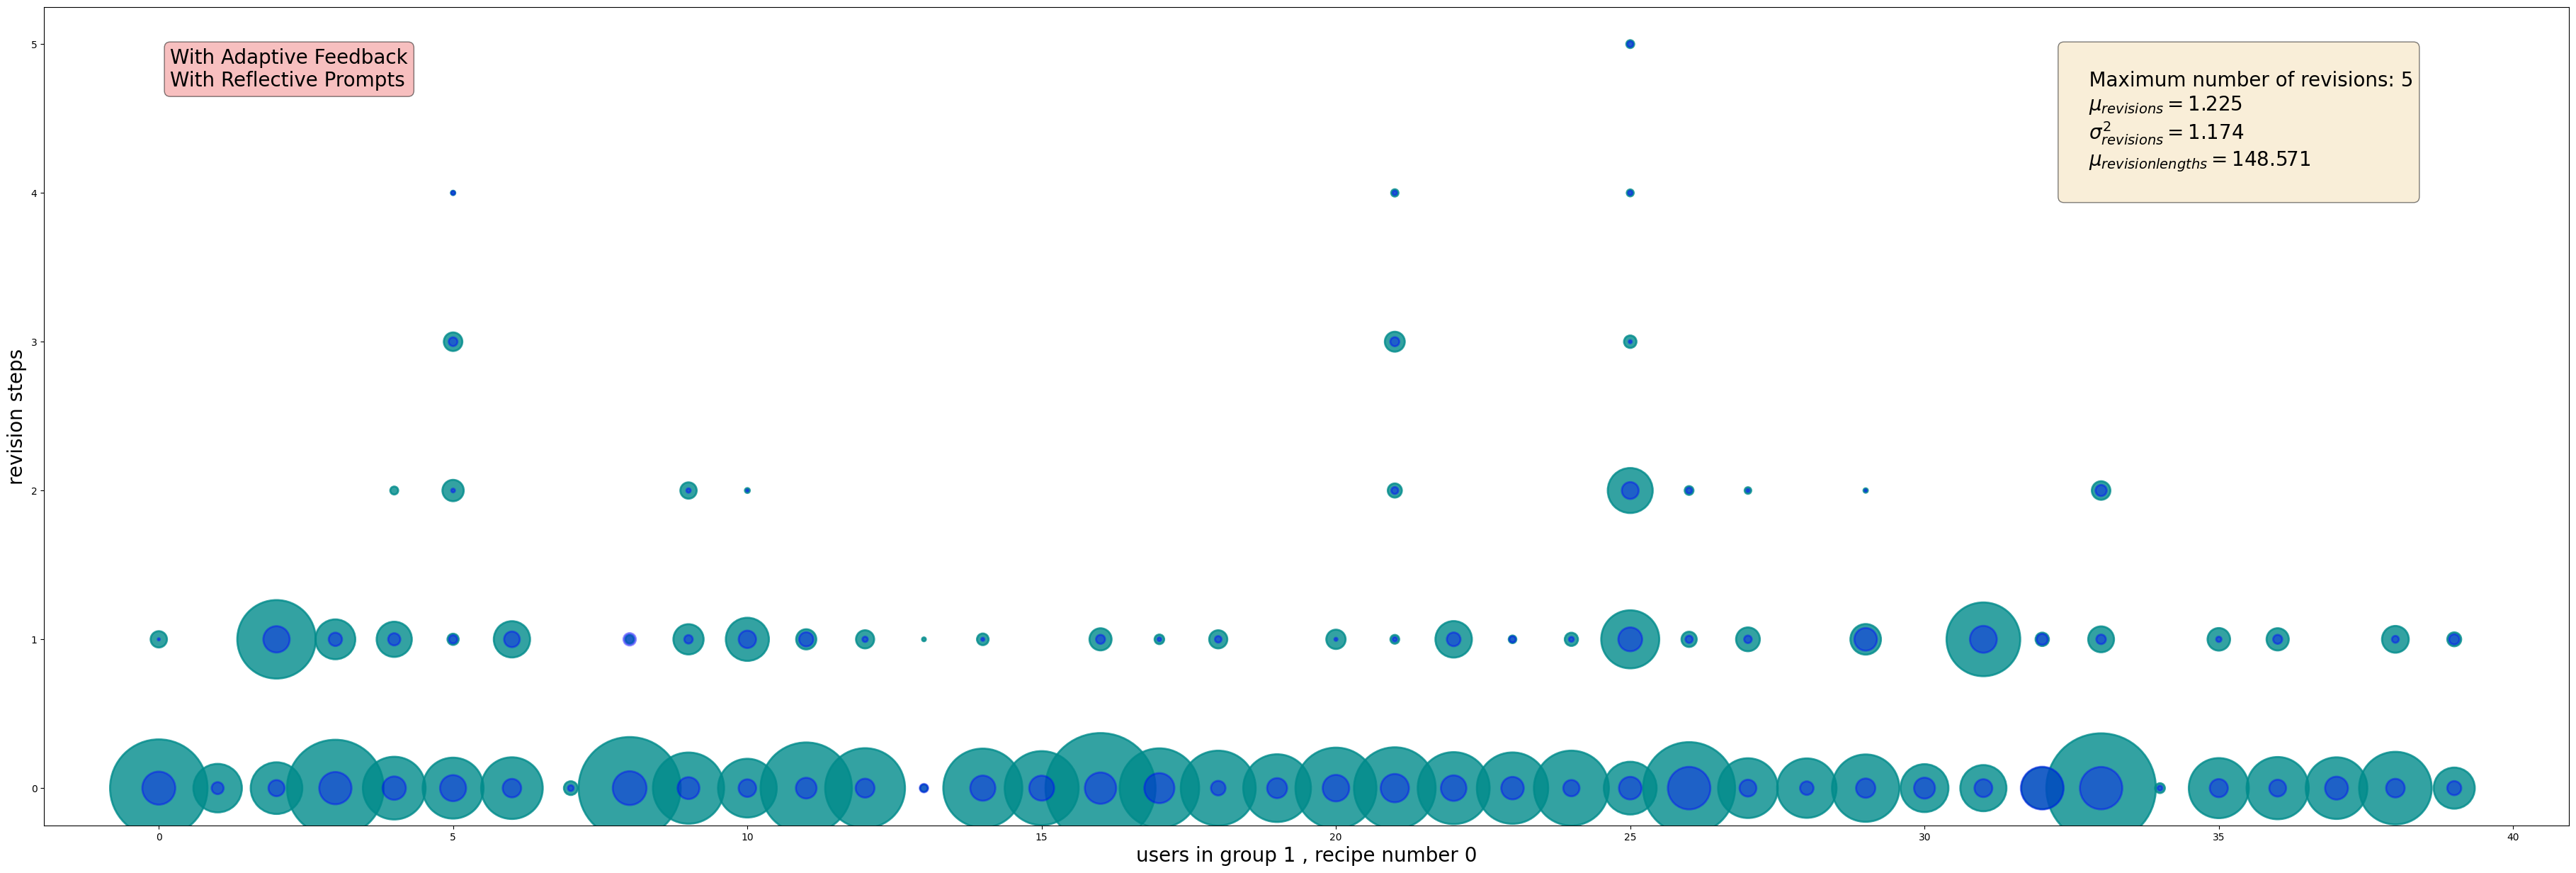

In [142]:
#so this plots the revisions made by users in the first group for the 1st recipe they write.
NTH_RECIPE = 0
max_revisions, means, variances, avr_rev_lengths = data_computation_on_groups(NTH_RECIPE)
group_characteristics = ["With Adaptive Feedback\nWith Reflective Prompts", "With Adaptive Feedback\nWithout Reflective Prompts", 
"Without Adaptive Feedback\nWith Reflective Prompts", "Without Adaptive Feedback\nWithout Reflective Prompts", "Control Group\nNo Adaptive Feedback\nNo Reflective Prompts"]
for group in range(1,2):
    text = \
    """
    Maximum number of revisions: {max}
    {mean}
    {var}
    {revision_length_mean}
    """.format(max=max_revisions[group-1], 
    mean=r'$\mu_{revisions}=%.3f$' % (means[group-1]), 
    var=r'$\sigma^2_{revisions}=%.3f$' % (variances[group-1]),
    revision_length_mean=r'$\mu_{revision lengths}=%.3f$' % (avr_rev_lengths[group-1])
    )

    plot_group_at_recipe(group_n=group, recipe_number=NTH_RECIPE, vertical=True, xlabel="users in group {group} , recipe number {num_recipe}".format(group=group, num_recipe=NTH_RECIPE), ylabel="revision steps", text_to_display=text, group_characteristics=group_characteristics[group-1])

print(sorted_users[INDICES[0][0]])
#we can see that the revisions made are very small.

5f16bc9496b2453bc7739c0b
353    Ingredients\n\n140g plain flour\n200ml whole m...
354    Ingredients\n140g plain flour\n200ml whole mil...
355    500 gm of minced meat\n1 grated onion\nSome fi...
356    500 gm of minced meat\n1 grated onion\nSome fi...
357    Ingredients\n350g self-raising flour, plus mor...
Name: recipe, dtype: object
[353, 355, 357]
5f16bc9496b2453bc7739c0b
[(11, 15), (3, 0)]
[(68, 43), (5, 0)]
[(3, 0)]


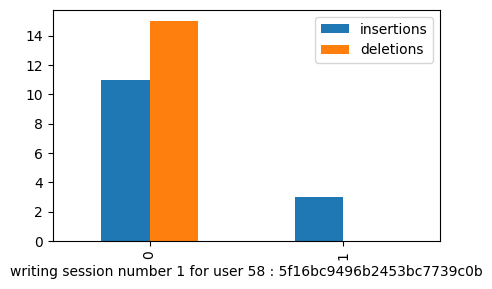

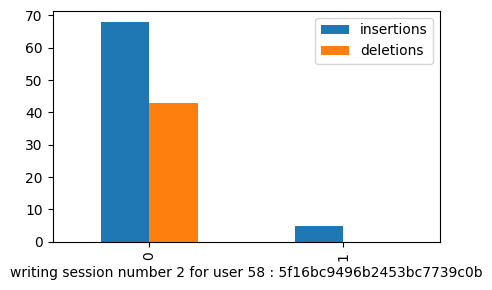

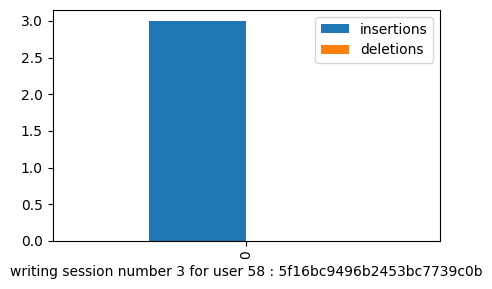

In [141]:
def print_user_recipes(index):
    print(sorted_users[index])
    a = np.where(df['user_id'] == sorted_users[index])
    for i in a:
        print(df['recipe'].iloc[i])
    print(map_[index])

a = INDICES[0][13]
print_user_recipes(a)
plot_users_sessions(a)


In [133]:
import os
import pm4py

log = pm4py.read_xes(os.path.join("tests","input_data","running-example.xes"))

    
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)

FileNotFoundError: [Errno 2] No such file or directory: 'tests\\input_data\\running-example.xes'